# Surface Mass Balance: PCA 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [69]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

Set WD

#### Load KM_L 

In [70]:
import glob


# Define the directory path where the CSV files are located
input_path =r'../../data/promice/preprocessed/daily/'
pattern = '*.csv'
#staion_list = ['SCO_L.csv','KAN_L.csv']

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

data_collection = []
for file in filenames:
    data = pd.read_csv(file, index_col=False)
    data_collection.append(data)
data = pd.concat(data_collection)

data = data.reset_index(drop=True)

#data = pd.read_csv('../data//promice/preprocessed/daily/SCO_L.csv')
data = data.drop(['Unnamed: 0','Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1)
#data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d')


In [71]:
# Defining stations
display(data['stid'].unique())

#promice_stations = [
#    "KPC_L", "KPC_Lv3", "KPC_U", "KPC_Uv3", "SCO_L", "SCO_U", "MIT", "TAS_L",
#    "TAS_U", "TAS_A", "QAS_L", "QAS_Lv3", "QAS_U", "QAS_Uv3", "QAS_A", "NUK_L",
#    "NUK_U", "NUK_Uv3", "NUK_K", "NUK_N", "KAN_B", "KAN_L", "KAN_M", "KAN_U",
#    "UPE_L", "UPE_U", "THU_L", "THU_L2", "THU_U", "THU_U2", "CEN", "CEN1",
#3    "SWC", "SWC_O", "JAR", "JAR_O", "EGP"
#]
promice_stations = [
    "KPC_L", "KPC_Lv3", "KPC_Uv3", "SCO_L", "SCO_U", "MIT", "TAS_L",
    "TAS_U", "TAS_A", "QAS_L", "QAS_Lv3", "QAS_U", "QAS_Uv3", "QAS_A", "NUK_L",
    "NUK_U", "NUK_K", "KAN_B", "KAN_L", "KAN_M", "KAN_U",
    "UPE_L", "UPE_U", "THU_L", "THU_U", "THU_U2", "CEN", "CEN1",
    "SWC_O", "JAR_O", "EGP"
]
promice_stations = ['KPC_L','SCO_L','THU_L','UPE_L','MIT','TAS_L','KAN_L','NUK_L','NUK_U','QAS_L','QAS_U']

# Removed stations due to lagging years
# THU_L2, SWC, NUK_Uv3, NUK_N, KPC_U, JAR
length_of_list = len(promice_stations)
data = data.loc[data['stid'].isin(promice_stations)]

#KPC_LSCO_LSCO_UTHU_L UPE_L UPE_U MIT TAS_L KAN_L NUK_L NUK_U QAS_L QAS_U



print(data.columns)


array(['CEN1', 'CEN2', 'CP1', 'DY2', 'EGP', 'HUM', 'JAR', 'JAR_O',
       'KAN_B', 'KAN_L', 'KAN_M', 'KAN_U', 'KPC_L', 'KPC_Lv3', 'KPC_U',
       'KPC_Uv3', 'LYN_L', 'LYN_T', 'MIT', 'NAE', 'NAU', 'NEM', 'NSE',
       'NUK_K', 'NUK_L', 'NUK_N', 'NUK_U', 'NUK_Uv3', 'QAS_A', 'QAS_L',
       'QAS_Lv3', 'QAS_M', 'QAS_U', 'QAS_Uv3', 'Roof_GEUS',
       'Roof_PROMICE', 'SCO_L', 'SCO_U', 'SDL', 'SDM', 'SWC', 'SWC_O',
       'TAS_A', 'TAS_L', 'TAS_U', 'THU_L', 'THU_L2', 'THU_U', 'THU_U2',
       'TUN', 'UPE_L', 'UPE_U', 'UWN', 'WEG_B', 'ZAK_L', 'ZAK_U',
       'ZAK_Uv3'], dtype=object)

Index(['stid', 'Datetime', 'Air pressure (upper boom)',
       'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Wind from direction (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover', 'Ablation',
       'Melting Season'],
      dtype='object')


## PCA

##### Pre-processing (0.1: Change months to cycle)

In [81]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
df = data.copy()
# This bit to split Datetime column into year, month, day, hour columns

#Create new columns
#df['year'] = df['Datetime'].dt.year 
#df['month'] = df['Datetime'].dt.month
#df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [82]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

#cyclical = CyclicalFeatures(variables=None, drop_original=True)

# with year
#cyclical = cyclical.fit_transform(df[['month', 'year', 'Wind from direction (upper boom)']]) 

# Remove only values from Wind direction because CyclicalFeatures does not work with NAN
#cyclical_df = df[df['Wind from direction (upper boom)'].notna()] 

# without year 
#cyclical = cyclical.fit_transform(df[['month', 'Wind from direction (upper boom)']]) 

# without month
#cyclical = cyclical.fit_transform(cyclical_df[['Wind from direction (upper boom)']]) 
#df = pd.merge(df, cyclical, left_index=True, right_index=True)

#df.drop(columns=['Wind from direction (upper boom)'], inplace=True)

##### Pre-processing (1.0: Filter relevant periods)

In [83]:
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')
display(df)

,stid,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,Downwelling longwave radiation,Upwelling longwave radiation,Surface temperature,Latent heat flux (upper boom),Sensible heat flux (upper boom),Albedo,Cloud cover,Ablation,Melting Season
57347,KAN_L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,beginning
57348,KAN_L,930.272417,4.067042,80.716750,4.420708,4.616417,151.127125,79.998500,43.203958,305.296625,318.976333,0.000,10.214708,45.592458,0.545000,0.684958,True,beginning
57349,KAN_L,928.642042,2.856625,84.547542,4.257667,2.589208,130.834917,99.346417,51.914583,310.954875,317.836000,0.000,1.970375,13.956375,0.525000,0.808042,True,beginning
57350,KAN_L,927.952250,2.757833,75.053708,3.746167,3.055417,126.096500,167.023750,95.056417,282.167458,317.062542,0.000,-7.634542,17.556875,0.568125,0.507583,True,middle
57351,KAN_L,914.642583,2.768333,87.821500,4.468500,2.539667,127.975583,49.319542,28.411292,323.629292,318.614667,0.000,3.087167,13.924292,0.576571,0.945250,True,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235173,UPE_L,970.000000,-20.140000,89.621000,0.585000,1.577000,140.400000,0.000000,0.000000,228.658000,224.836000,-22.243,0.309000,4.436000,NaN,0.960000,False,no_ablation
235174,UPE_L,982.000000,-22.460000,90.690000,0.467000,1.721000,118.800000,0.000000,0.000000,221.492000,209.081000,-26.839,0.488000,5.683000,NaN,0.973000,False,no_ablation
235175,UPE_L,967.000000,-19.830000,67.258000,0.454000,1.727000,125.900000,0.000000,0.000000,229.224000,209.519000,-26.777,0.277000,6.031000,NaN,0.954000,False,no_ablation
235176,UPE_L,961.000000,-9.320000,73.548000,1.314000,7.498000,175.700000,0.000000,0.000000,244.172000,260.119000,-12.773,0.175000,78.003000,NaN,0.681000,False,no_ablation


In [84]:
#Only Ablation Period

#df = df[df['Ablation'] == True]

#Only Melting Season
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#On all periods (without NA)
#df = df.dropna()

#df = df.reset_index(drop=True)

In [85]:
# This bit retrieve the indexes for all melting season categories and remove column from df
periods = ['all','no_ablation','pre','beginning', 'middle','end']

periods = ['all','no_ablation','pre','beginning', 'middle','end']

for category in ['no_ablation', 'pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

#df.drop(columns=['Melting Season'], inplace=True) 

indices_beginning

Int64Index([ 57347,  57348,  57349,  57608,  57609,  57610,  57611,  57612,
             57613,  57614,
            ...
            234933, 234934, 234935, 234936, 234937, 234938, 234939, 234940,
            234941, 234942],
           dtype='int64', length=2050)

##### This bit to apply PCA and save as output df

In [87]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

preprocess_df = df.copy()
scaler = MinMaxScaler()

#preprocess_df = preprocess_df.loc[preprocess_df['Ablation'] == True]
preprocess_df['Albedo'] = preprocess_df['Albedo'].bfill()

#print(df.columns)
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'month_sin', 'month_cos', 'Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y and cyclical feature
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos',  'Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y and cyclical feature
num_cols = preprocess_df.select_dtypes(include=['int64','float64']).columns #.drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos'], axis=1).columns #select numerical columns except y and cyclical feature

#df[num_cols] = df[num_cols].ffill().bfill()
preprocess_df[num_cols] = scaler.fit_transform(preprocess_df[num_cols])

pca_col = preprocess_df.select_dtypes(include=['int64','float64']).columns #select numerical columns except y and cyclical feature


print('preprocess pre dropna', preprocess_df.shape)
preprocess_df.dropna(inplace=True)
print('preprocess post dropna', preprocess_df.shape)
pca = PCA()
pca.fit(preprocess_df[pca_col])

# calculate the cumulative variance explained by each PC
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_var > 0.9) + 1  # select the minimum number of PCs that explain at least 90% of the variance

# fit PCA with the selected number of components
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(preprocess_df[pca_col])

# create a new dataframe with the PCA columns
pca_df = pd.DataFrame(pca_data, columns=['PC'+str(i) for i in range(1, n_components+1)])

# concatenate the original dataframe without the PCA columns with the PCA dataframe
original_df = preprocess_df.drop(columns=pca_col)
result_df = pd.concat([original_df, pca_df], axis=1)

station = df.iloc[0]['stid']
#result_df.to_csv(r'../../data/promice/preprocessed/daily/all_PCA.csv'.format(station=station))


preprocess pre dropna (58322, 18)
preprocess post dropna (43134, 18)


##### This bit to analysze PCA for different periods  

In [78]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# This bit to convert all numerical values into the same scale 
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'month_sin', 'month_cos', 'Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y and cyclical feature


#scaler = MinMaxScaler()
#scaler = StandardScaler()


#df[num_cols] = df[num_cols].ffill().bfill()
#df[num_cols] = scaler.fit_transform(df[num_cols])

**PCA** - Plotting functions

In [79]:
def plot_cum_variance(x_vals, cum_var):
    plt.plot(x_vals, cum_var)
    plt.xlabel('Number of Component')
    plt.ylabel('Cumulative Variance Explained')
    plt.title(' The Optimal Number of PC')
    plt.show()

def plot_pca_loadings(labels_vals, loadings):
    fig, axes = plt.subplots(1, len(labels_vals), figsize=(len(labels_vals)*10, 10))

    for i, label in enumerate(labels_vals):
        pc_loadings = loadings.abs().sort_values(by=label, ascending=False)[[label]]
        pc_loadings = pc_loadings.reset_index()
        pc_loadings.columns = ['Attribute', 'CorrelationWithPC{}'.format(i+1)]
        axes[i].bar(x=pc_loadings['Attribute'], height=pc_loadings['CorrelationWithPC{}'.format(i+1)], color='#087E8B')
        axes[i].set_title('PCA loading scores (principal component {})'.format(i+1), size=10)
        axes[i].tick_params(axis='x', rotation=90)

    plt.show()




def plot_pca_vert(labels_vals,loadings, absolute=False):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=1, ncols=len(loadings.columns), figsize=(15,5), sharey=True)
    if absolute:
        loadings = loadings.abs()
    loadings = loadings.sort_values(by=loadings.columns[0],ascending=True)
    for i, col in enumerate(loadings.columns):

        loadings[col].plot(kind='barh', ax=axes[i], color='#087E8B')
            
        axes[i].set_title(labels_vals[i], size=12)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Correlation', size=10)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)
        axes[i].set_yticks(np.arange(len(loadings.index)))
        axes[i].set_yticklabels(loadings.index, fontsize=8)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.1)
    plt.show()


**PCA** - iterative function, cycling through all periods

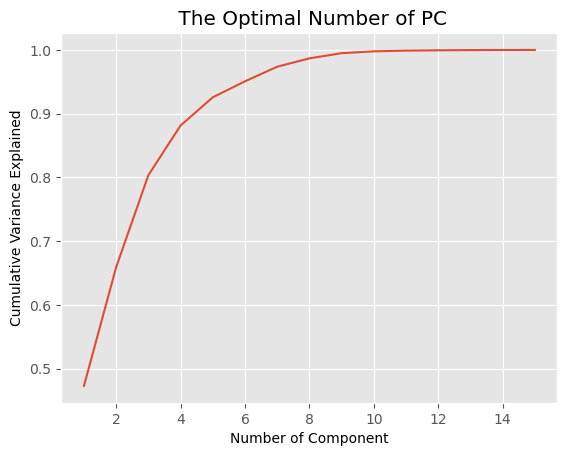

,PC 1 (47.3%),PC 2 (18.6%),PC 3 (14.4%),PC 4 (7.8%),PC 5 (4.4%)
Air pressure (upper boom),0.000592,-0.010183,0.030060,-0.001995,0.006869
Air temperature (upper boom),-0.000113,-0.030861,0.020051,0.012669,0.021497
Relative humidity (upper boom) - corrected,-0.089154,0.003867,-0.014817,0.061389,-0.072593
Specific humidity (upper boom),-0.059956,-0.051108,0.018405,0.060803,-0.014160
Wind speed (upper boom),0.008181,0.000490,0.004827,-0.012518,0.007390
Wind from direction (upper boom),0.003305,0.119399,0.149956,0.011130,-0.005466
Downwelling shortwave radiation - corrected,0.088614,-0.012739,0.001921,0.081552,0.038408
Upwelling shortwave radiation - corrected,0.057034,0.037122,-0.029352,0.060309,0.029425
Downwelling longwave radiation,-0.070009,-0.014133,0.010186,0.008580,0.022959
Upwelling longwave radiation,-0.007044,-0.013288,0.011162,0.008044,0.007708


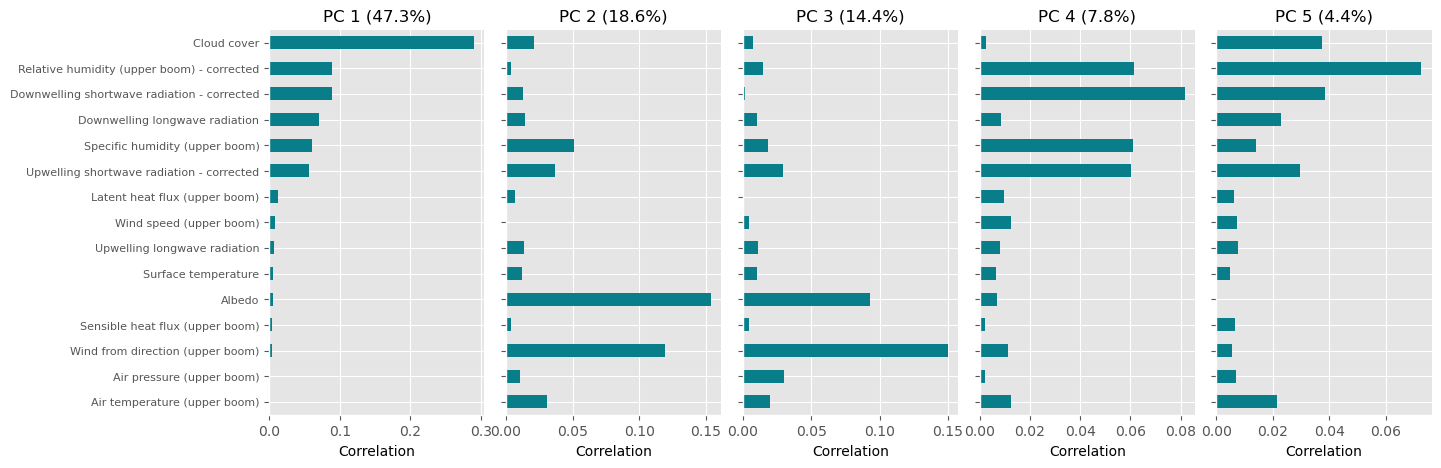

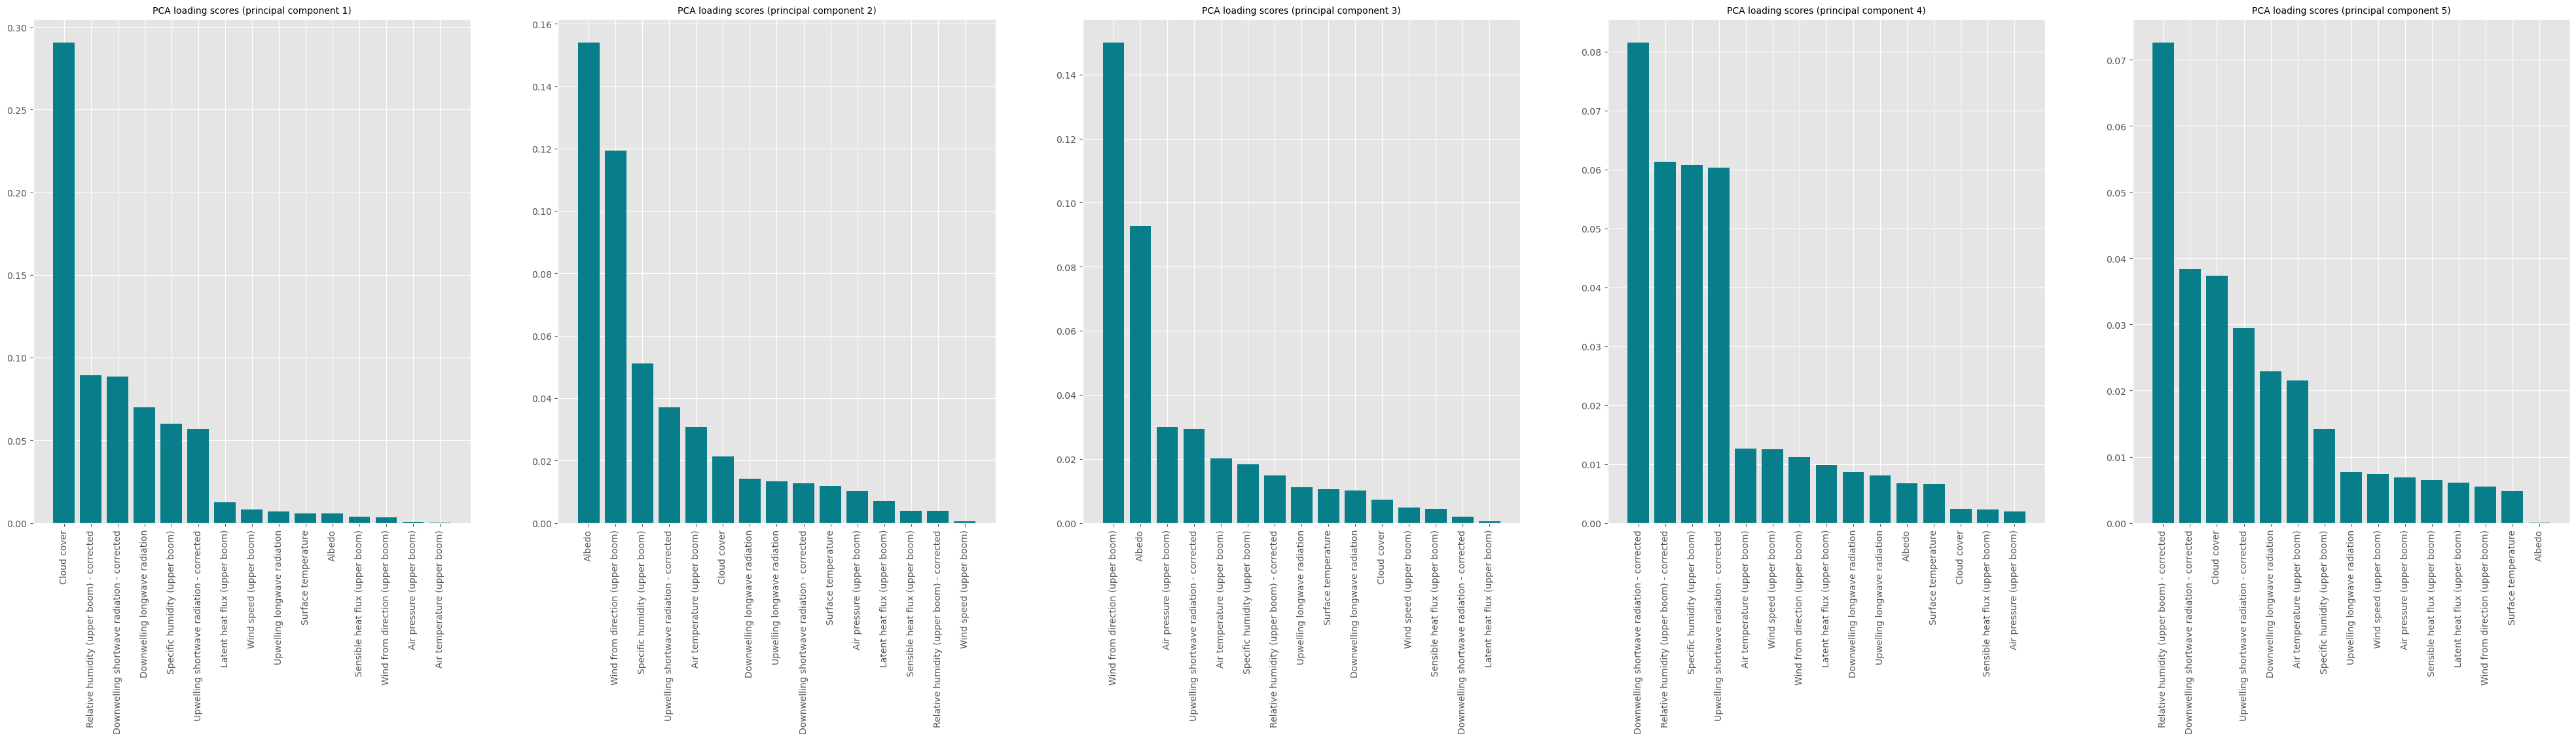

In [90]:
# Apply PCA
from sklearn.decomposition import PCA
preprocess_df = preprocess_df.loc[preprocess_df['Ablation'] == True]

pca_col = preprocess_df.select_dtypes(include=['int64','float64']).columns #select numerical columns except y

pca = PCA()
pca.fit(preprocess_df[pca_col])

cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
x_values = list(range(1, len(cumulative_variance_explained)+1))

#Visualizing arm-bar plot 
plot_cum_variance(x_values, cumulative_variance_explained)


#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

#Transform data with the optimal number of components
pca = PCA(n_components = optimal_component)

pca_data = pca.fit_transform(preprocess_df[pca_col])

labels = {
str(i):f"PC {i+1} ({var:.1f}%)"
for i, var in enumerate(pca.explained_variance_ratio_*100)
}

labels_vals = list(labels.values())
loadings = pd.DataFrame(
data=pca.components_.T * np.sqrt(pca.explained_variance_), 
columns= labels_vals,
index=  preprocess_df[pca_col].columns
)
display(loadings)



plot_pca_vert(labels_vals, loadings, absolute=True)
plot_pca_loadings(labels_vals, loadings)



---------------------

### Test Suite

In [91]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

#Transform data with the optimal number of components
pca = PCA(n_components = optimal_component)

X_train_pca = pca.fit_transform(preprocess_df[num_cols])
X_test_pca = pca.transform(preprocess_df[num_cols])

labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_*100)
    }
print(type(pca.explained_variance_ratio_))


def pca_relationship(pca_model):
    #color_map = {
    #'beginning': 'green',
    #'middle': 'yellow',
    #'end': 'red'
    #}
    fig = px.scatter_matrix(
        pca_model,
        labels=labels,
        dimensions=range(4),
        color= 'red'
        )#X_train['Melting Season'],
        #color_discrete_map=color_map)
    
    fig.update_traces(diagonal_visible=False)
    fig.show()

def pca_heatmap(dataframe):
    #plot a heatmap to visualise how the feature variables contribute to PC
    # Heatmap
    plt.figure(figsize=(16, 16))

    heatmap = sns.heatmap(dataframe, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

    heatmap.set_title('Correlation Heatmap')
    plt.show()

pca_df = pd.DataFrame(pca.components_,
                columns = num_cols,
                index =labels.values(),
                )
pca_heatmap(pca_df)
pca_relationship(X_train_pca)




SyntaxError: invalid syntax (158758883.py, line 28)

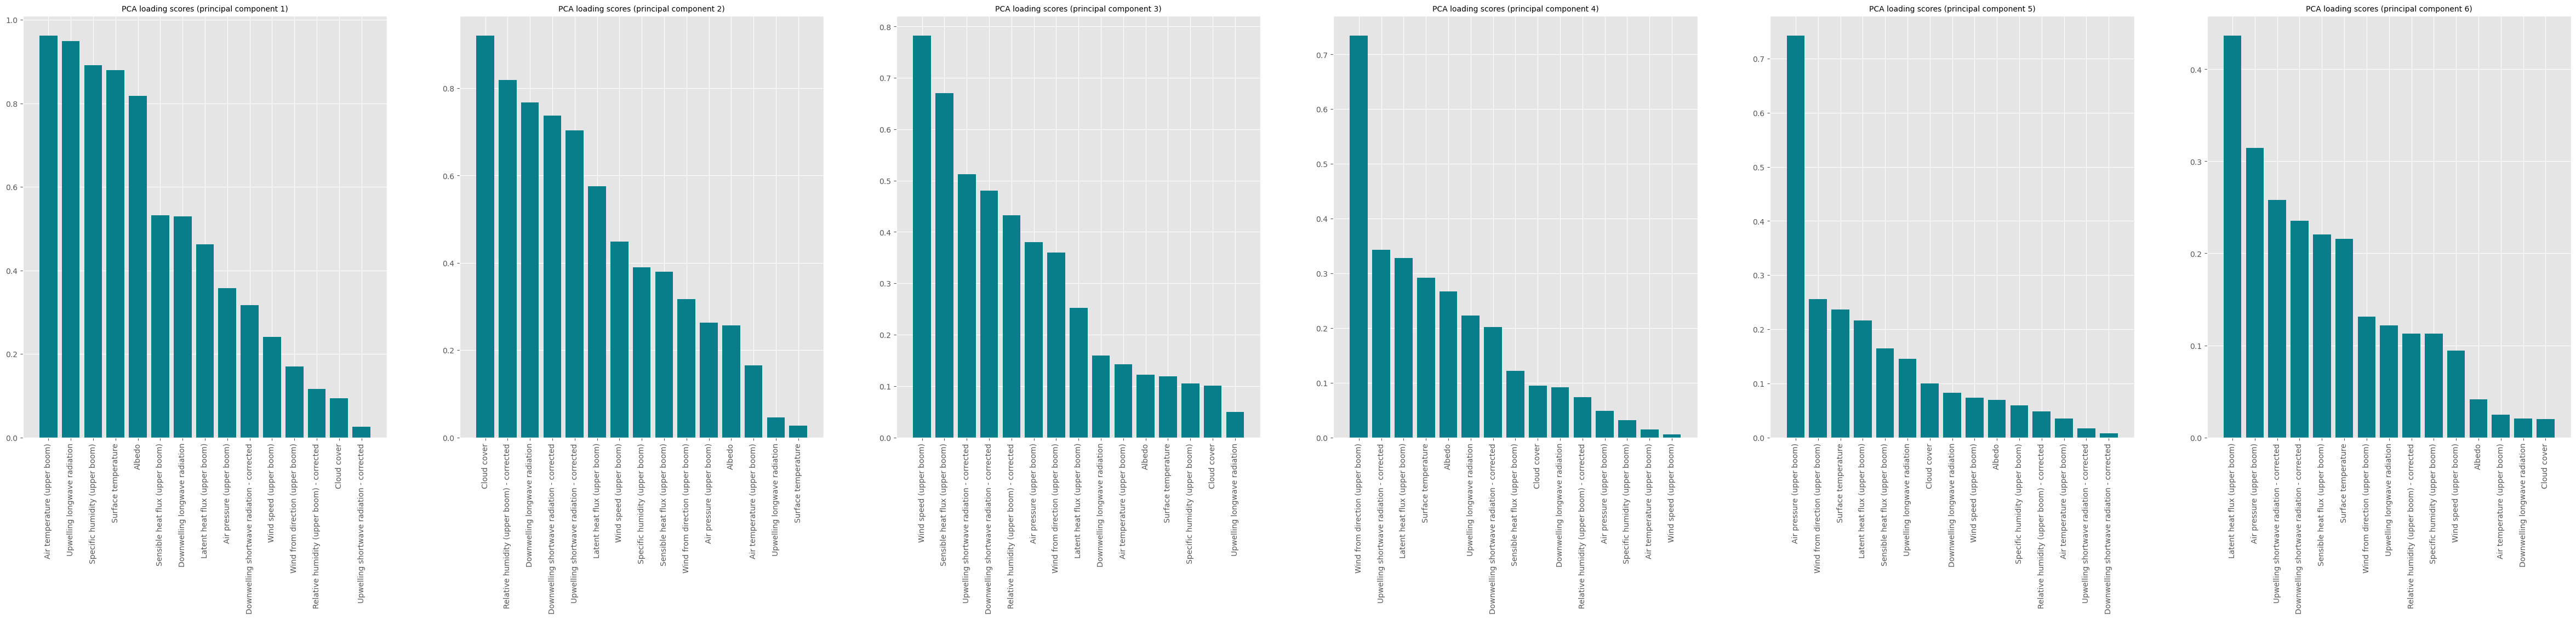

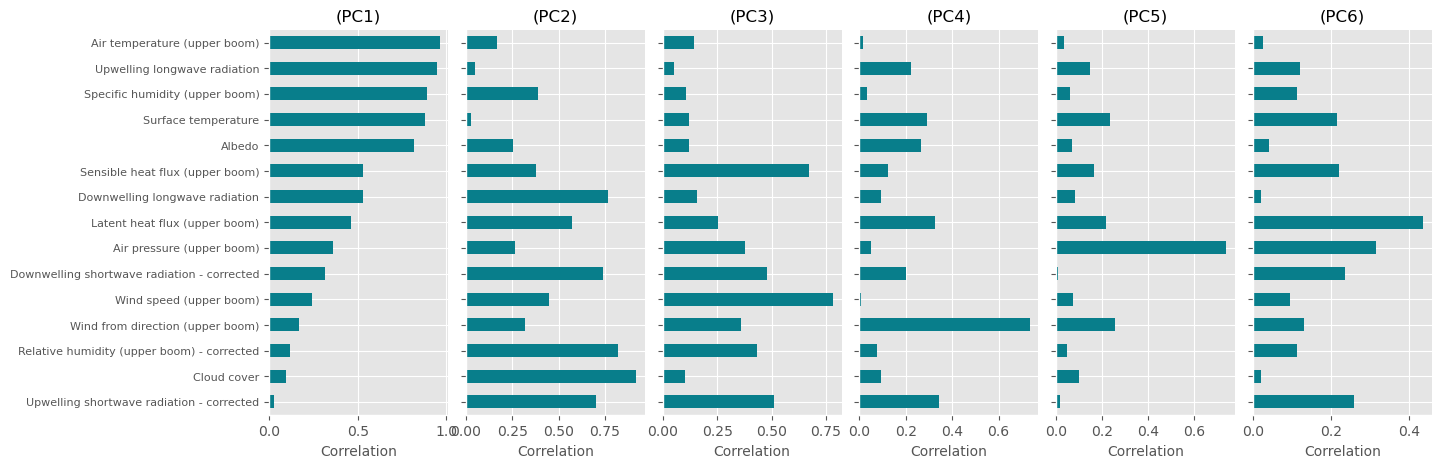

In [298]:
labels_vals = list(labels.values())
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= labels_vals,
    index=  X_train[num_cols].columns
)

def plot_pca_loadings(labels_vals, loadings):
    fig, axes = plt.subplots(1, len(labels_vals), figsize=(len(labels_vals)*10, 10))

    for i, label in enumerate(labels_vals):
        pc_loadings = loadings.abs().sort_values(by=label, ascending=False)[[label]]
        pc_loadings = pc_loadings.reset_index()
        pc_loadings.columns = ['Attribute', 'CorrelationWithPC{}'.format(i+1)]
        axes[i].bar(x=pc_loadings['Attribute'], height=pc_loadings['CorrelationWithPC{}'.format(i+1)], color='#087E8B')
        axes[i].set_title('PCA loading scores (principal component {})'.format(i+1), size=10)
        axes[i].tick_params(axis='x', rotation=90)

    plt.show()

plot_pca_loadings(labels_vals, loadings)


def plot_pca_stacked(labels_vals, loadings):
    fig, axs = plt.subplots(nrows=len(loadings.columns), sharey=True, figsize=(8, 10))

    # Loop over each column in the loadings dataframe and create a bar chart for each feature
    for i, col in enumerate(loadings.columns):
        axs[i].bar(x=loadings.index, height=loadings[col].abs(), color='#087E8B')
        axs[i].set_title(col)
        axs[i].tick_params(labelbottom=False, bottom=False)  # Hide x-axis labels and ticks for all subplots except the bottom one
        axs[i].spines['right'].set_visible(False)  # Hide right spines for all subplots
        axs[i].spines['top'].set_visible(False)  # Hide top spines for all subplots
        if i == len(loadings.columns) - 1:
            axs[i].tick_params(labelbottom=True, bottom=True, labelrotation=90)

    # Set y-axis label and adjust subplots layout
    fig.text(0, 0.5, 'Contribution to PCA', va='center', rotation='vertical')
    fig.tight_layout(pad=1.5)
    plt.show()

#plot_pca_stacked(labels_vals, loadings)

def plot_pca_vert(labels_vals,loadings, absolute=False):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=1, ncols=len(loadings.columns), figsize=(15,5), sharey=True)
    if absolute:
        loadings = loadings.abs()
    loadings = loadings.sort_values(by=loadings.columns[0],ascending=True)
    for i, col in enumerate(loadings.columns):

        loadings[col].plot(kind='barh', ax=axes[i], color='#087E8B')
            
        axes[i].set_title(f'(PC{i+1})', size=12)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Correlation', size=10)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)
        axes[i].set_yticks(np.arange(len(loadings.index)))
        axes[i].set_yticklabels(loadings.index, fontsize=8)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.1)
    plt.show()

plot_pca_vert(labels_vals, loadings, absolute=True)

-------------------------------- Without Imputation ---------------------------------------------------

In [299]:
#  We can follow this paper: https://www.sciencedirect.com/science/article/pii/S1574954121000261#:~:text=The%20standard%20algorithm%20of%20PCA%20is%20modified%20to%20accommodate%20incomplete%20data.&text=The%20method%20produces%20ordination%20scores%20for%20variables%20and%20observations%20simultaneously.&text=Information%20is%20maximally%20exhausted%2C%20while%20data%20imputation%20is%20not%20required.
# Or: https://github.com/allentran/pca-magic

import os

import numpy as np
from scipy.linalg import orth

class PPCA():

    def __init__(self):

        self.raw = None   # original data
        self.data = None  # standardized data
        self.C = None     # principal component matrix
        self.means = None # mean of data
        self.stds = None  # standard deviation of data
        self.eig_vals = None # eigenvalues of the covariance matrix

    def _standardize(self, X):
        """
        Internal function to standardize input data.

        Args:
            X (array): Input data to be standardized.

        Returns:
            array: Standardized data.
        """

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return (X - self.means) / self.stds

    def fit(self, data, d=None, tol=1e-4, min_obs=10, verbose=False):
        """
        Fit the PPCA model to the input data.

        Args:
            data (array): Input data to fit the model.
            d (int, optional): Number of principal components to keep. Defaults to None, which is the same as the number of dimensions of the data.
            tol (float, optional): Tolerance for convergence. Defaults to 1e-4.
            min_obs (int, optional): Minimum number of observations required for a variable to be included in the model. Defaults to 10.
            verbose (bool, optional): Print the difference value for each iteration. Defaults to False.

        Raises:
            RuntimeError: If the model is not fit before calling _standardize function.

        Returns:
            None
        """

        self.raw = data
        self.raw[np.isinf(self.raw)] = np.max(self.raw[np.isfinite(self.raw)])

        valid_series = np.sum(~np.isnan(self.raw), axis=0) >= min_obs

        data = self.raw[:, valid_series].copy()
        N = data.shape[0]
        D = data.shape[1]

        self.means = np.nanmean(data, axis=0)
        self.stds = np.nanstd(data, axis=0)

        data = self._standardize(data)
        observed = ~np.isnan(data)
        missing = np.sum(~observed)
        data[~observed] = 0

        # initial

        if d is None:
            d = data.shape[1]
        
        if self.C is None:
            C = np.random.randn(D, d)
        else:
            C = self.C
        CC = np.dot(C.T, C)
        X = np.dot(np.dot(data, C), np.linalg.inv(CC))
        recon = np.dot(X, C.T)
        recon[~observed] = 0
        ss = np.sum((recon - data)**2)/(N*D - missing)

        v0 = np.inf
        counter = 0

        while True:

            Sx = np.linalg.inv(np.eye(d) + CC/ss)

            # e-step
            ss0 = ss
            if missing > 0:
                proj = np.dot(X, C.T)
                data[~observed] = proj[~observed]
            X = np.dot(np.dot(data, C), Sx) / ss

            # m-step
            XX = np.dot(X.T, X)
            C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
            CC = np.dot(C.T, C)
            recon = np.dot(X, C.T)
            recon[~observed] = 0
            ss = (np.sum((recon-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)

            # calc diff for convergence
            det = np.log(np.linalg.det(Sx))
            if np.isinf(det):
                det = abs(np.linalg.slogdet(Sx)[1])
            v1 = N*(D*np.log(ss) + np.trace(Sx) - det) \
                + np.trace(XX) - missing*np.log(ss0)
            diff = abs(v1/v0 - 1)
            if verbose:
                print(diff)
            if (diff < tol) and (counter > 5):
                break

            counter += 1
            v0 = v1


        C = orth(C)
        vals, vecs = np.linalg.eig(np.cov(np.dot(data, C).T))
        order = np.flipud(np.argsort(vals))
        vecs = vecs[:, order]
        vals = vals[order]

        C = np.dot(C, vecs)

        # attach objects to class
        self.C = C
        self.data = data
        self.eig_vals = vals
        self._calc_var()

    def transform(self, data=None):

        if self.C is None:
            raise RuntimeError('Fit the data model first.')
        if data is None:
            return np.dot(self.data, self.C)
        return np.dot(data, self.C)

    def _calc_var(self):

        if self.data is None:
            raise RuntimeError('Fit the data model first.')

        data = self.data.T

        # variance calc
        var = np.nanvar(data, axis=1)
        total_var = var.sum()
        self.var_exp = self.eig_vals.cumsum() / total_var

    def save(self, fpath):

        np.save(fpath, self.C)
        
    def load(self, fpath):

        assert os.path.isfile(fpath)

        self.C = np.load(fpath)

['Air pressure (upper boom)', 'Air temperature (upper boom)', 'Relative humidity (upper boom) - corrected', 'Specific humidity (upper boom)', 'Wind speed (upper boom)', 'Wind from direction (upper boom)', 'Downwelling shortwave radiation - corrected', 'Upwelling shortwave radiation - corrected', 'Downwelling longwave radiation', 'Upwelling longwave radiation', 'Surface temperature', 'Latent heat flux (upper boom)', 'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover']


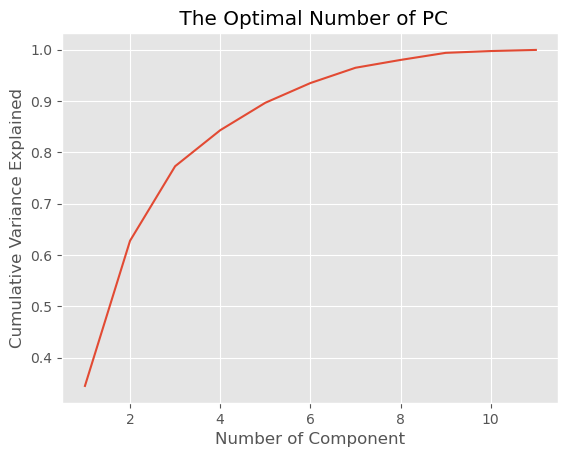

In [301]:
pp_X_train, pp_X_test,pp_y_train, pp_y_test = train_test_split(X,y,
                                   test_size=0.2, 
                                   random_state=2023,
                                   shuffle=False)

# This bit to convert all numerical values into the same scale 
num_cols = X.select_dtypes(include=['int64','float64']).columns.to_list()

scaler = MinMaxScaler()
scaler = StandardScaler()

pp_X_train[num_cols] = scaler.fit_transform(pp_X_train[num_cols])
pp_X_test[num_cols] = scaler.fit_transform(pp_X_test[num_cols])

ppca = PPCA()

ppca.fit(data = pp_X_train[num_cols].to_numpy(), d=30)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = ppca.var_exp
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()


[0.34521785 0.62791141 0.77309524 0.84313077 0.89655808 0.93479221]
[0.3452178502356563, 0.2826935609490995, 0.14518383244534705, 0.07003552504982036, 0.05342731063348283, 0.03823413219790095]
{'0': 'PC 1 (34.5%)', '1': 'PC 2 (28.3%)', '2': 'PC 3 (14.5%)', '3': 'PC 4 (7.0%)', '4': 'PC 5 (5.3%)', '5': 'PC 6 (3.8%)'}


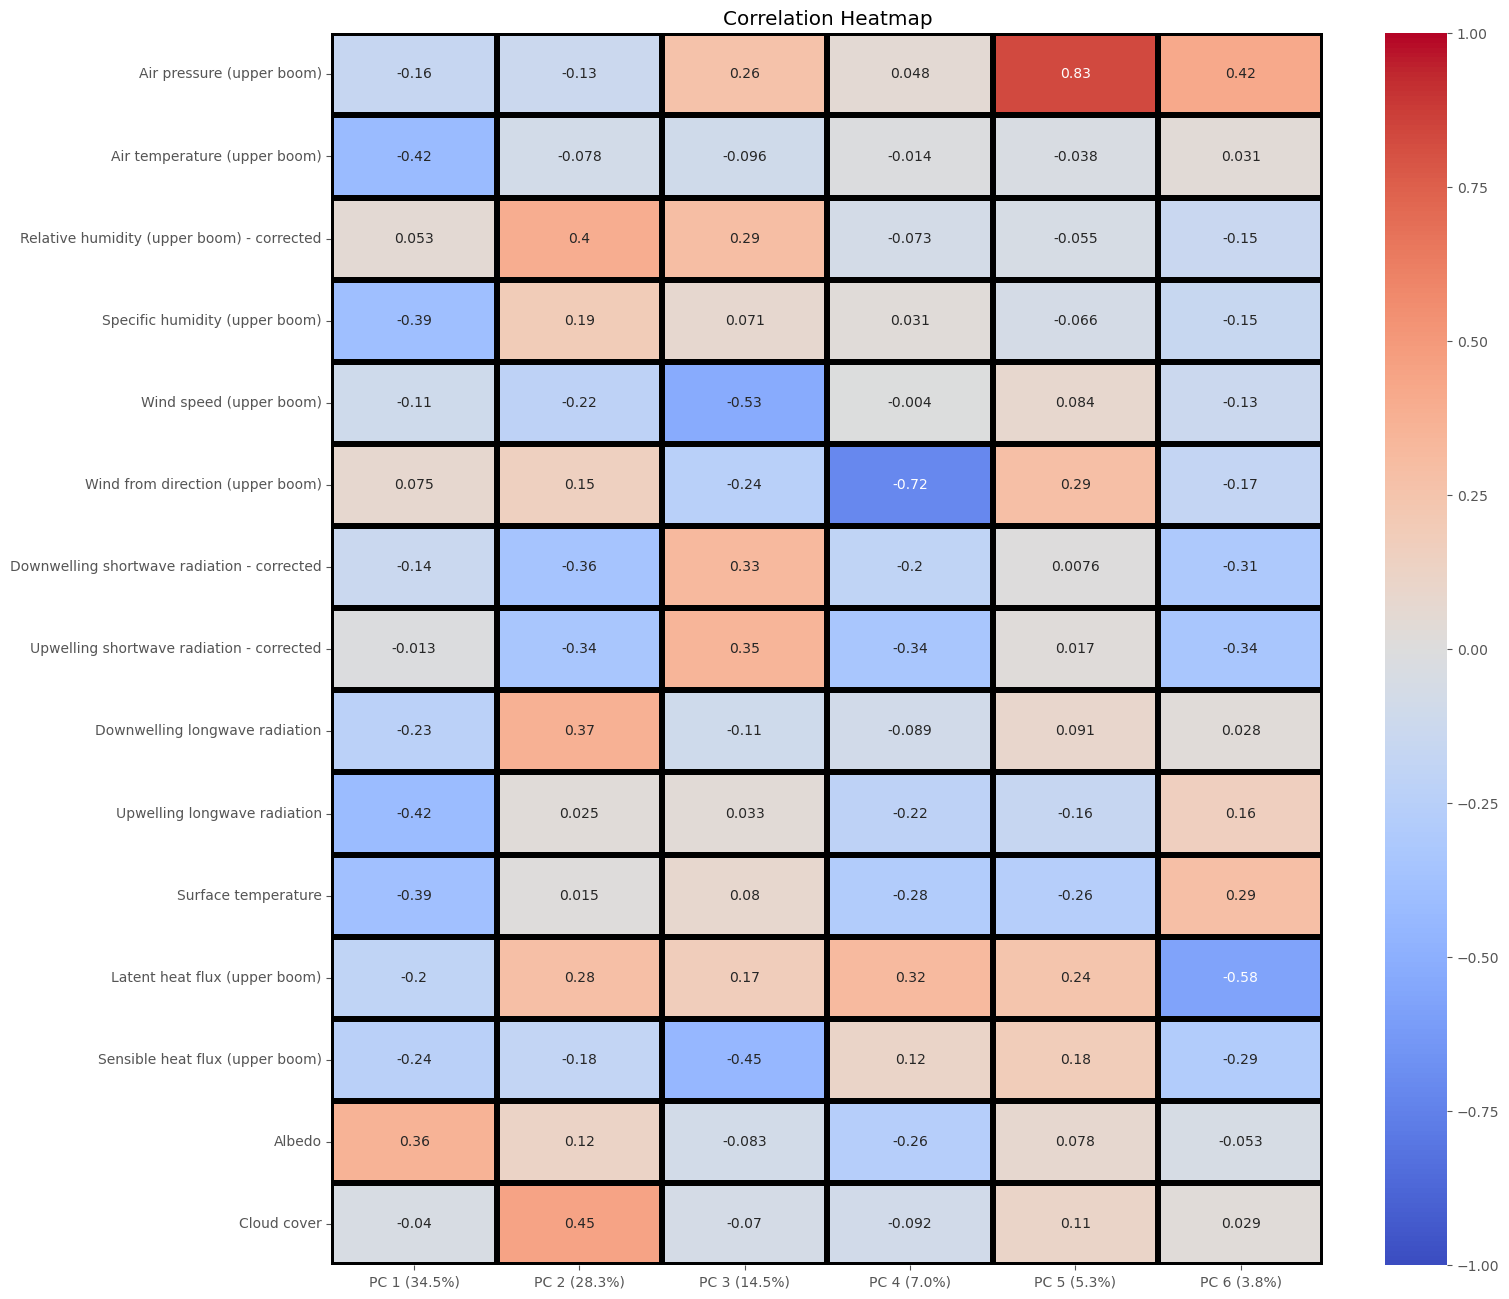

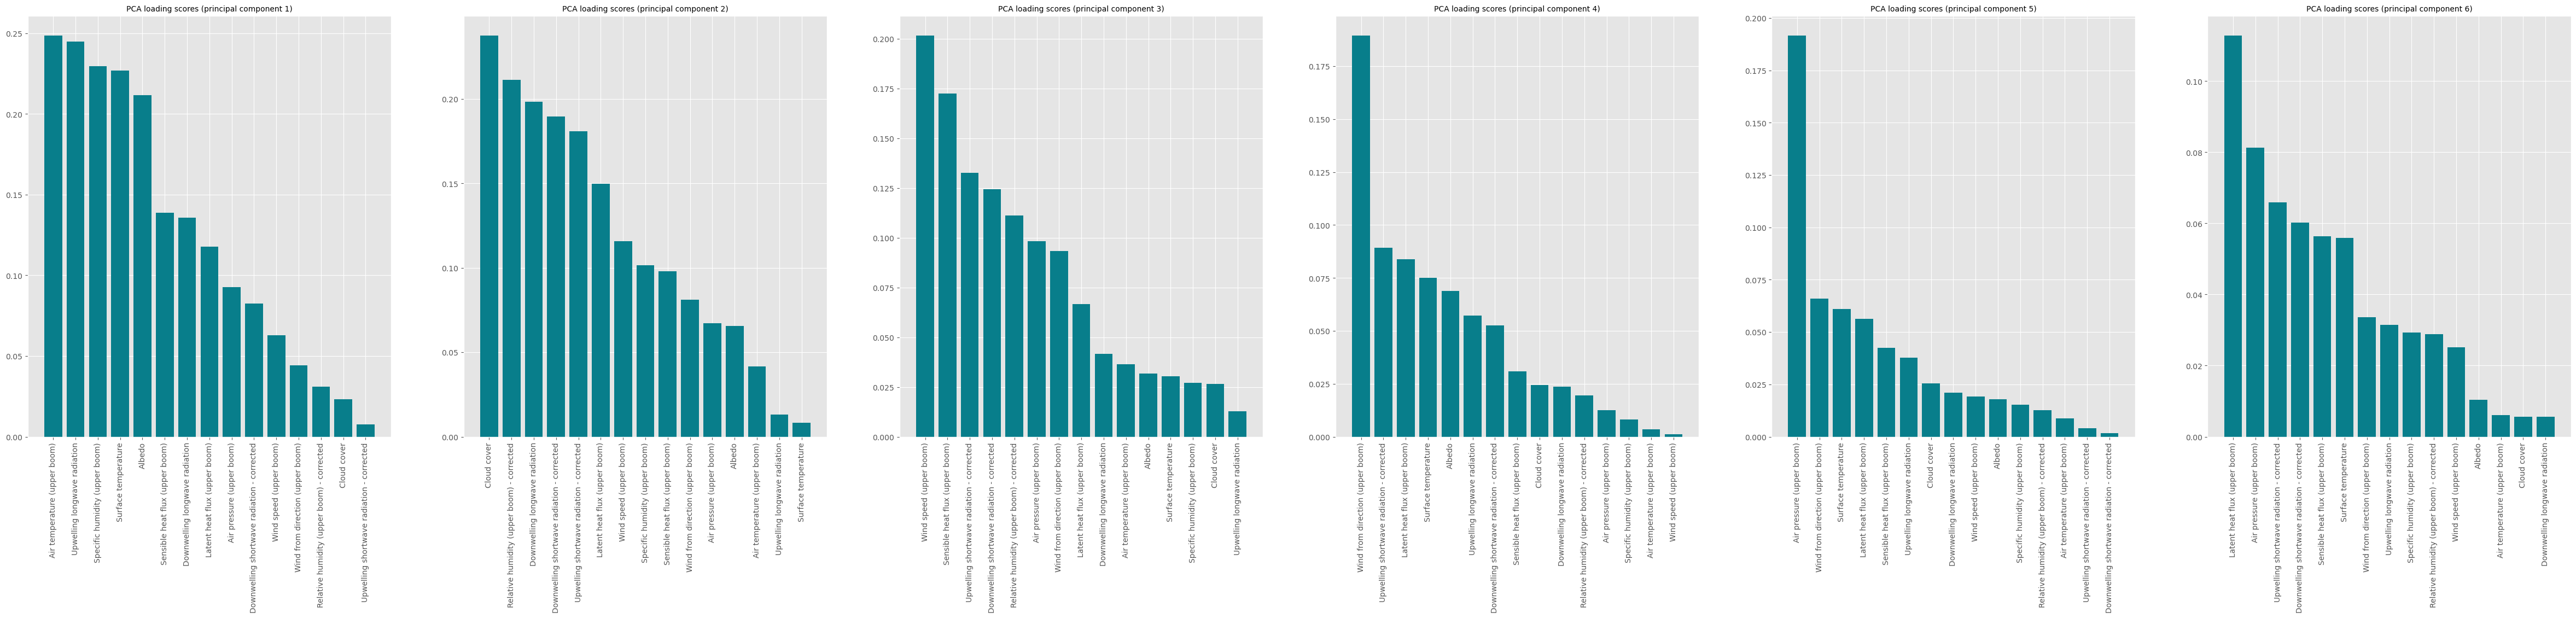

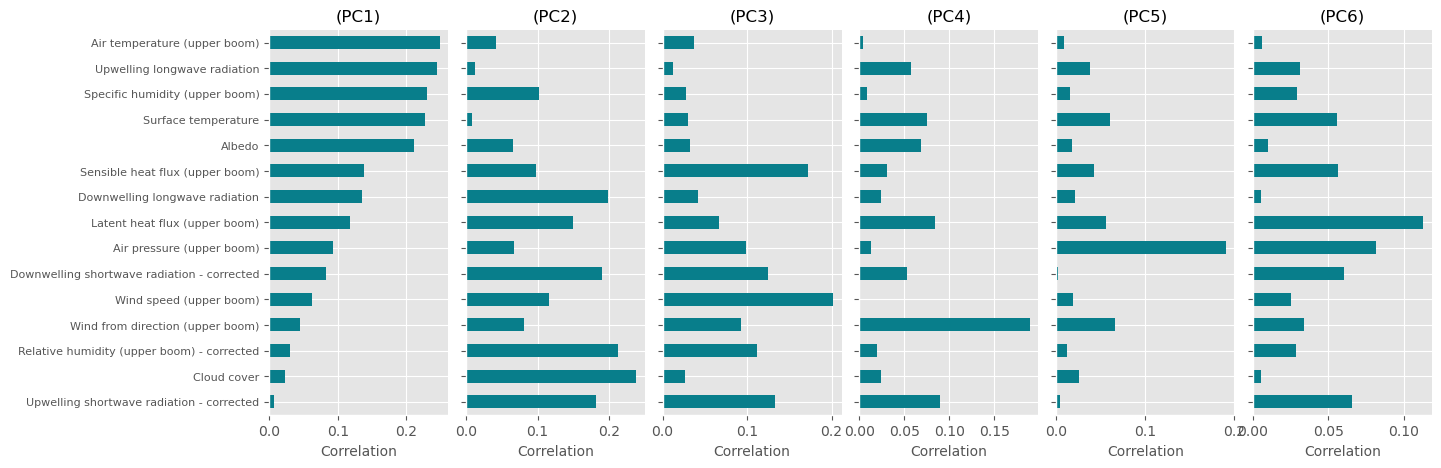

In [306]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

variance_explained = [ppca.var_exp[i] - ppca.var_exp[i-1] for i in range(1, len(ppca.var_exp))]
variance_explained.insert(0,ppca.var_exp[0])


ppca_labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(np.array(variance_explained)*100)
    }

ppca = PPCA()

X_train_ppca = ppca.fit(data = pp_X_train[num_cols].to_numpy(), d=optimal_component) 
X_train_ppca = ppca.transform(X_train_ppca)
X_test_ppca = ppca.transform(pp_X_test[num_cols].to_numpy())

# see how much features contribute to which components
ppca_df = pd.DataFrame(ppca.C,
                       columns = ppca_labels.values(),
                       index =pp_X_train[num_cols].columns)
ppca_df.head()

pca_heatmap(ppca_df)
pca_relationship(X_train_ppca)
pp_labels_vals = list(labels.values())
pp_loadings = pd.DataFrame(
    data=ppca.C * np.sqrt(variance_explained), 
    columns= pp_labels_vals,
    index=  pp_X_train[num_cols].columns
)
plot_pca_loadings(pp_labels_vals, pp_loadings)
plot_pca_vert(pp_labels_vals, pp_loadings, absolute=True)
